In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# 日本語フォントの指定
mpl.rcParams['font.family'] = 'IPAexGothic' # ここにインストールしたフォント名を入れる

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from nyaggle.feature.category_encoder import TargetEncoder

from nyaggle.experiment import run_experiment

In [2]:
train = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/train_feature_ver2.csv')
test = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/test_feature_ver2.csv')
era = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/era.csv')
sample_submission = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/sample_submission.csv')

In [3]:
test.head()

,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,...,502,503,504,505,506,507,508,509,510,511
0,NaN,工芸品,日本,江戸,京都府（京都府）,NaN,NaN,相国寺,NaN,NaN,...,-0.025584,-0.012252,-0.012271,0.072874,-0.039801,-0.021271,0.012467,0.034596,-0.023817,-0.030492
1,NaN,絵画,日本,平安,和歌山県（和歌山県）,NaN,NaN,西禅院,財団法人高野山文化財保存会,NaN,...,-0.026519,-0.036004,-0.035254,0.027655,0.045121,-0.018657,0.041083,0.062436,-0.019814,-0.036495
2,NaN,絵画,日本,平安,東京都（東京都）,東京都世田谷区上野毛3-9-25,公益財団法人五島美術館,東急株式会社,NaN,35.612290,...,0.032094,-0.013380,-0.010027,0.061131,-0.004584,-0.046228,0.044919,0.028419,-0.051641,-0.015564
3,NaN,近世以前／神社,NaN,江戸前期,和歌山県,和歌山県有田郡広川町大字上中野,NaN,廣八幡宮,NaN,34.017835,...,-0.025453,-0.023700,0.009060,0.075206,0.018822,-0.062776,0.016009,-0.022042,-0.035110,-0.050560
4,NaN,彫刻,日本,平安,山形県（山形県）,NaN,NaN,吉祥院,NaN,NaN,...,-0.037568,-0.031847,-0.014172,0.075822,0.017364,-0.073429,-0.018416,0.025913,0.005010,-0.012969


In [4]:
#categorical変数抽出
cat_cols = [c for c in test.columns if train[c].dtype == np.object]
cat_cols.remove('string') # これは取り除かないといけない

# numerical変数抽出
num_cols = [c for c in test.columns if train[c].dtype != np.object]

#目的変数抽出
target_col = 'is_kokuhou'

print(cat_cols)
print(num_cols)
print(target_col)

['棟名', '種別2', '国', '時代', '都道府県 ※美工品は「所有者住所（所在都道府県）」', '所在地', '保管施設の名称', '所有者名', '管理団体又は責任者']
['緯度', '経度', '開始', '終了', '緯度*経度', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [5]:
# target encoding

# kf = KFold(4)
# kf = KFold(4, groups=train.categorical)　#GroupKFold
kf = StratifiedKFold(5, shuffle=True, random_state=42531) #StratifiedKFold

# Target encoding with K-fold
# te = TargetEncoder(kf.split(train))
# te = TargetEncoder(kf.split(train)) #GroupKFold
te = TargetEncoder(kf.split(train, train[target_col])) #StratifiedKFold

# use fit/fit_transform to train data, then apply transform to test data
train.loc[:, cat_cols] = te.fit_transform(train[cat_cols], train[target_col])
test.loc[:, cat_cols] = te.transform(test[cat_cols])

In [6]:
print(len(cat_cols) + len(num_cols))

526


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.260879
[2]	valid_0's binary_logloss: 0.257172
[3]	valid_0's binary_logloss: 0.254803
[4]	valid_0's binary_logloss: 0.252655
[5]	valid_0's binary_logloss: 0.250033
[6]	valid_0's binary_logloss: 0.248346
[7]	valid_0's binary_logloss: 0.247005
[8]	valid_0's binary_logloss: 0.245225
[9]	valid_0's binary_logloss: 0.243425
[10]	valid_0's binary_logloss: 0.242193
[11]	valid_0's binary_logloss: 0.241471
[12]	valid_0's binary_logloss: 0.240307
[13]	valid_0's binary_logloss: 0.23954
[14]	valid_0's binary_logloss: 0.238473
[15]	valid_0's binary_logloss: 0.23705
[16]	valid_0's binary_logloss: 0.235871
[17]	valid_0's binary_logloss: 0.235567
[18]	valid_0's binary_logloss: 0.23519
[19]	valid_0's binary_logloss: 0.234414
[20]	valid_0's binary_logloss: 0.234015
[21]	valid_0's binary_logloss: 0.233133
[22]	valid_0's binary_logloss: 0.232818
[23]	valid_0's binary_logloss: 0.231798
[24]	valid_0's binary_logloss: 0.231584
[25]	valid_0's binary_logloss: 0.231601
[26]	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.260793
[2]	valid_0's binary_logloss: 0.258224
[3]	valid_0's binary_logloss: 0.25348
[4]	valid_0's binary_logloss: 0.250402
[5]	valid_0's binary_logloss: 0.24834
[6]	valid_0's binary_logloss: 0.24716
[7]	valid_0's binary_logloss: 0.246053
[8]	valid_0's binary_logloss: 0.24414
[9]	valid_0's binary_logloss: 0.243032
[10]	valid_0's binary_logloss: 0.241659
[11]	valid_0's binary_logloss: 0.240244
[12]	valid_0's binary_logloss: 0.238933
[13]	valid_0's binary_logloss: 0.238173
[14]	valid_0's binary_logloss: 0.237065
[15]	valid_0's binary_logloss: 0.236504
[16]	valid_0's binary_logloss: 0.236383
[17]	valid_0's binary_logloss: 0.235951
[18]	valid_0's binary_logloss: 0.234867
[19]	valid_0's binary_logloss: 0.234663
[20]	valid_0's binary_logloss: 0.234301
[21]	valid_0's binary_logloss: 0.234397
[22]	valid_0's binary_logloss: 0.234312
[23]	valid_0's binary_logloss: 0.23389
[24]	valid_0's binary_logloss: 0.233671
[25]	valid_0's binary_logloss: 0.23344
[26]	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.259138
[2]	valid_0's binary_logloss: 0.253874
[3]	valid_0's binary_logloss: 0.249459
[4]	valid_0's binary_logloss: 0.245486
[5]	valid_0's binary_logloss: 0.242815
[6]	valid_0's binary_logloss: 0.240288
[7]	valid_0's binary_logloss: 0.238595
[8]	valid_0's binary_logloss: 0.236666
[9]	valid_0's binary_logloss: 0.234864
[10]	valid_0's binary_logloss: 0.232795
[11]	valid_0's binary_logloss: 0.231197
[12]	valid_0's binary_logloss: 0.229924
[13]	valid_0's binary_logloss: 0.228625
[14]	valid_0's binary_logloss: 0.226984
[15]	valid_0's binary_logloss: 0.226141
[16]	valid_0's binary_logloss: 0.225403
[17]	valid_0's binary_logloss: 0.224596
[18]	valid_0's binary_logloss: 0.223728
[19]	valid_0's binary_logloss: 0.222717
[20]	valid_0's binary_logloss: 0.221851
[21]	valid_0's binary_logloss: 0.220995
[22]	valid_0's binary_logloss: 0.220468
[23]	valid_0's binary_logloss: 0.220067
[24]	valid_0's binary_logloss: 0.21937
[25]	valid_0's binary_logloss: 0.218742
[26]	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.26177
[2]	valid_0's binary_logloss: 0.256534
[3]	valid_0's binary_logloss: 0.252649
[4]	valid_0's binary_logloss: 0.248768
[5]	valid_0's binary_logloss: 0.2466
[6]	valid_0's binary_logloss: 0.244405
[7]	valid_0's binary_logloss: 0.241901
[8]	valid_0's binary_logloss: 0.239813
[9]	valid_0's binary_logloss: 0.23803
[10]	valid_0's binary_logloss: 0.236747
[11]	valid_0's binary_logloss: 0.235852
[12]	valid_0's binary_logloss: 0.234972
[13]	valid_0's binary_logloss: 0.234147
[14]	valid_0's binary_logloss: 0.232577
[15]	valid_0's binary_logloss: 0.23186
[16]	valid_0's binary_logloss: 0.230796
[17]	valid_0's binary_logloss: 0.23011
[18]	valid_0's binary_logloss: 0.228967
[19]	valid_0's binary_logloss: 0.228943
[20]	valid_0's binary_logloss: 0.228403
[21]	valid_0's binary_logloss: 0.227615
[22]	valid_0's binary_logloss: 0.227237
[23]	valid_0's binary_logloss: 0.226988
[24]	valid_0's binary_logloss: 0.226066
[25]	valid_0's binary_logloss: 0.225401
[26]	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.260209
[2]	valid_0's binary_logloss: 0.254772
[3]	valid_0's binary_logloss: 0.248614
[4]	valid_0's binary_logloss: 0.244543
[5]	valid_0's binary_logloss: 0.242036
[6]	valid_0's binary_logloss: 0.23964
[7]	valid_0's binary_logloss: 0.237117
[8]	valid_0's binary_logloss: 0.234943
[9]	valid_0's binary_logloss: 0.233116
[10]	valid_0's binary_logloss: 0.231256
[11]	valid_0's binary_logloss: 0.2299
[12]	valid_0's binary_logloss: 0.228528
[13]	valid_0's binary_logloss: 0.226018
[14]	valid_0's binary_logloss: 0.224847
[15]	valid_0's binary_logloss: 0.224429
[16]	valid_0's binary_logloss: 0.223261
[17]	valid_0's binary_logloss: 0.222551
[18]	valid_0's binary_logloss: 0.221083
[19]	valid_0's binary_logloss: 0.219609
[20]	valid_0's binary_logloss: 0.218547
[21]	valid_0's binary_logloss: 0.217103
[22]	valid_0's binary_logloss: 0.216252
[23]	valid_0's binary_logloss: 0.215607
[24]	valid_0's binary_logloss: 0.2151
[25]	valid_0's binary_logloss: 0.21445
[26]	valid_0's 

/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 2

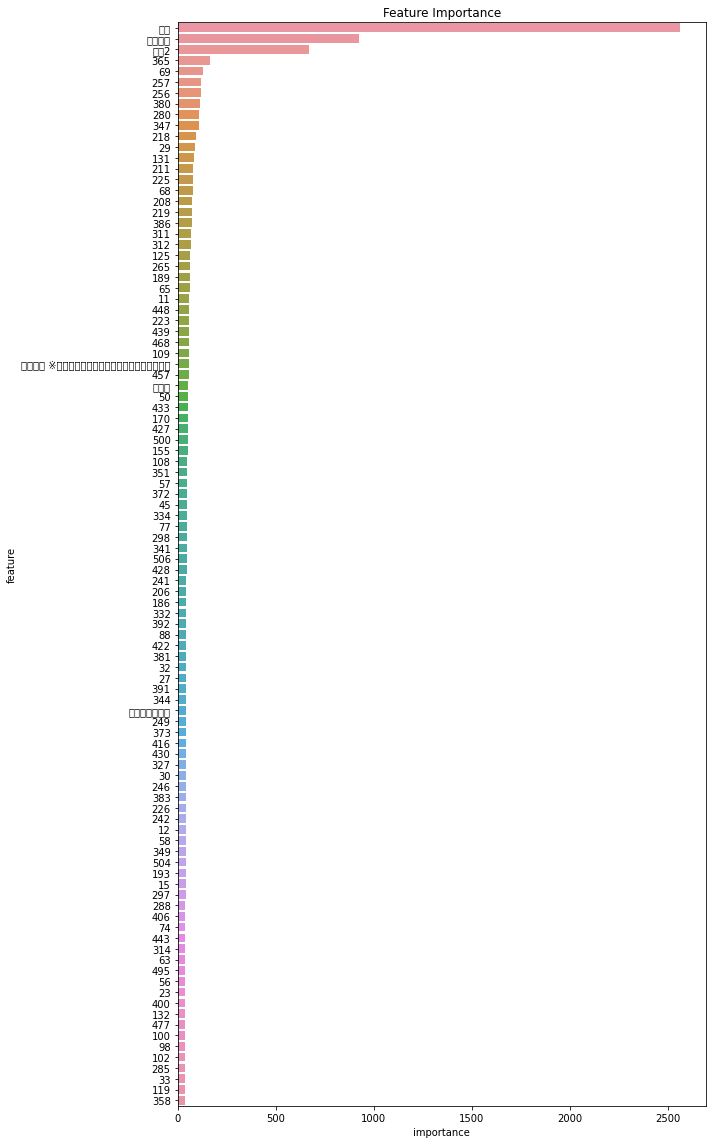

In [7]:
params = {
    'objective': "binary", # binary, multiclass, regression
    'metric': "binary_logloss", # mae, mse, auc, binary_logloss, multi_logloss, rmse, average_precision
    'learning_rate':0.05, #0.05
    'n_estimators': 10000,
    'max_depth': -1,
    'random_state' : 42531
    #'num_leaves' : 100, #カーディナリティが高い場合は大きくする
    #'max_bin' : 500,
}

result = run_experiment(params,
                        train[num_cols + cat_cols],
                        train[target_col],
                        test[num_cols + cat_cols],
                        cv=StratifiedKFold(5, shuffle=True, random_state=42531), #cv=5,
                        #groups=train.group
                        )

In [9]:
print(result.metrics) # Evalulation metrics for each fold

[0.7725885668276973, 0.7818236714975845, 0.8162882447665056, 0.817194041867955, 0.8370046513112228, 0.8053098184368901]


In [10]:
result.importance     # Feature importance for each fold

[                       feature   importance
 0                           緯度     6.522130
 1                           経度    22.353201
 2                           開始    48.681559
 3                           終了     7.072080
 4                        緯度*経度     0.000000
 ..                         ...          ...
 521  都道府県 ※美工品は「所有者住所（所在都道府県）」    67.590280
 522                        所在地    81.157310
 523                    保管施設の名称    22.410180
 524                       所有者名  1136.513637
 525                  管理団体又は責任者     0.000000
 
 [526 rows x 2 columns],
                        feature  importance
 0                           緯度    0.000000
 1                           経度    7.735720
 2                           開始    0.000000
 3                           終了    0.000000
 4                        緯度*経度    0.000000
 ..                         ...         ...
 521  都道府県 ※美工品は「所有者住所（所在都道府県）」   18.976700
 522                        所在地   67.853701
 523                    保管施設の名称   16.

In [11]:
print(result.test_prediction)  # Test prediction in numpy array
print(result.oof_prediction)   # Out-of-fold prediction in numpy array

[0.01772414 0.17224189 0.28548819 ... 0.11402205 0.01823263 0.01780899]
[0.01425341 0.09459712 0.3026155  ... 0.10790008 0.13101551 0.01867722]


In [12]:
train[target_col].to_numpy()

array([0, 0, 1, ..., 0, 0, 0])

In [14]:
# データ全体のF1スコアを計算 & 閾値の最適化
from sklearn.metrics import f1_score

def find_optimal_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_scores > threshold).astype(int)
        score = f1_score(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

# 例として使用するデータ（実際にはモデルからの予測値と実際のラベルを使用）
y_true = train[target_col].values
y_scores = result.oof_prediction

best_threshold, best_f1_score = find_optimal_threshold(y_true, y_scores)
print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

Best threshold: 0.16161616161616163
Best F1 Score: 0.34348561759729274


In [15]:
# 閾値を超える確率を持つ要素を1に、それ以外を0に変換
y_pred = (result.test_prediction > best_threshold).astype(int)
print(y_pred)
print(y_pred.shape)

[0 1 1 ... 0 0 0]
(10065,)


In [17]:
sample_submission['is_kokuhou'] = y_pred
sample_submission

,is_kokuhou
0,0
1,1
2,1
3,0
4,0
...,...
10060,0
10061,0
10062,0
10063,0


In [18]:
sample_submission["is_kokuhou"].value_counts()

0    9072
1     993
Name: is_kokuhou, dtype: int64

In [19]:
sample_submission.to_csv('lightgbm_ver3.csv', index=False)

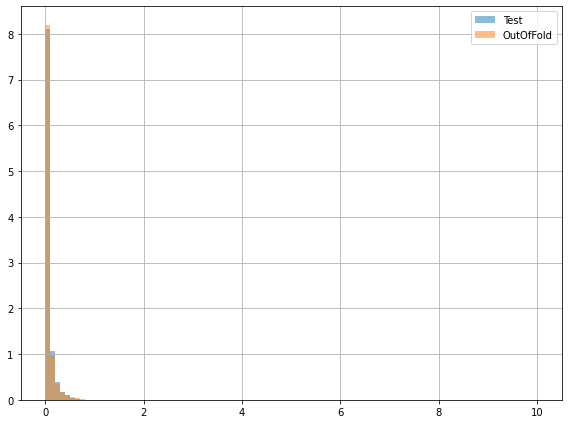

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(result.test_prediction, bins=bins, density=True, alpha=.5, label="Test")
ax.hist(result.oof_prediction, bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()